In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import pandas as pd 
import numpy as np 
from numpy import array

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
plt.style.use('seaborn-whitegrid')

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

### 수출금액 준비

In [3]:
pd.options.display.float_format = '{:.5f}'.format
df = pd.read_csv('수출금액50년.csv', encoding='cp949', index_col='Date', parse_dates=True)
#df = df.iloc[360:,:]
print(df.shape)
df.head()

(624, 7)


,한국수출금액_USD,한국수입금액_USD,무역수지,경기종합지수,한국소비자물가지수,다우존스지수,Exp_불규칙요소
Date,,,,,,,
1970-01-31,51046000,149889000,-98843000,4.40000,4.40000,753.12000,0.99656
1970-02-28,46889000,125666000,-78777000,4.50000,4.48800,777.59000,0.87996
1970-03-31,65906000,147048000,-81142000,4.50000,4.58600,785.57000,1.03290
1970-04-30,65910000,153829000,-87919000,4.50000,4.68400,736.07000,1.03613
1970-05-31,69923000,153741000,-83818000,4.60000,4.63700,700.44000,1.04536


In [4]:
df.isna().sum()

한국수출금액_USD    0
한국수입금액_USD    0
무역수지          0
경기종합지수        0
한국소비자물가지수     0
다우존스지수        0
Exp_불규칙요소     0
dtype: int64

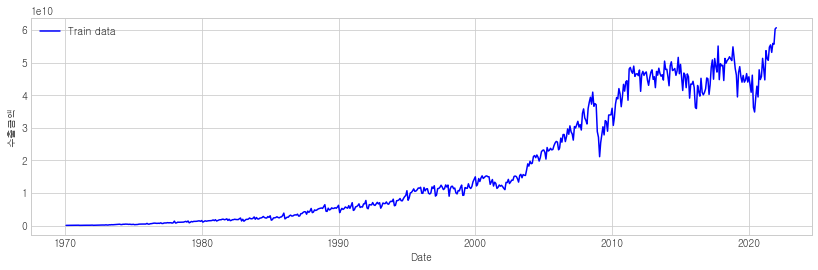

In [5]:
plt.figure(figsize=(14,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(df['한국수출금액_USD'], 'blue', label='Train data')
plt.legend()

### Input/ Output Sequence & 배열 설정

In [6]:
df_array = df['한국수출금액_USD'].values.reshape(- 1, 1) # Numpy arrary 배열 변환 

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()#(feature_range=(0, 1))
scaler = scaler.fit(df_array)
df_scaled = scaler.transform(df_array) # MinMax Scaler 조정 

In [8]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
window_size = 5 # Input Sequence : X1,X2,....XT
n_step_out = 6   # Output Sequence : Y1,Y2,....YT

In [10]:
X, Y = split_sequence(df_scaled, window_size, n_step_out)

In [11]:
X.shape,Y.shape

((614, 5, 1), (614, 6, 1))

In [12]:
#X --> X 배열 확인

In [13]:
#Y --> Y 배열 확인

### 1. LSTM Encoder & Decoder

In [14]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [15]:
tf.random.set_seed(0)

In [16]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(LSTM(28,activation='tanh',input_shape=(X.shape[1], X.shape[2]),return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(RepeatVector(6)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(64, activation='tanh', return_sequences=True)) # Decoder State 
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(16, activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X, Y, epochs= 200, batch_size=10, validation_split=0.1,callbacks=[early_stop])

Epoch 1/200
56/56 [==============================] - 7s 61ms/step - loss: 0.0679 - mae: 0.1754 - val_loss: 0.0546 - val_mae: 0.1733
Epoch 2/200
56/56 [==============================] - 0s 7ms/step - loss: 0.0103 - mae: 0.0621 - val_loss: 0.0206 - val_mae: 0.1088
Epoch 3/200
56/56 [==============================] - 0s 7ms/step - loss: 0.0051 - mae: 0.0439 - val_loss: 0.0227 - val_mae: 0.1269
Epoch 4/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0034 - mae: 0.0364 - val_loss: 0.0178 - val_mae: 0.1136
Epoch 5/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0032 - mae: 0.0355 - val_loss: 0.0111 - val_mae: 0.0865
Epoch 6/200
56/56 [==============================] - 0s 7ms/step - loss: 0.0024 - mae: 0.0282 - val_loss: 0.0079 - val_mae: 0.0711
Epoch 7/200
56/56 [==============================] - 0s 8ms/step - loss: 0.0017 - mae: 0.0256 - val_loss: 0.0090 - val_mae: 0.0769
Epoch 8/200
56/56 [==============================] - 0s 8ms/step - loss: 0.0016 - 

In [18]:
X_test= np.array([[[0.87527832],
        [0.92057218],
        [0.91639519],
        [0.99334993],
        [1.        ]]])

In [19]:
fit = model.predict(X_test)

<AxesSubplot:>

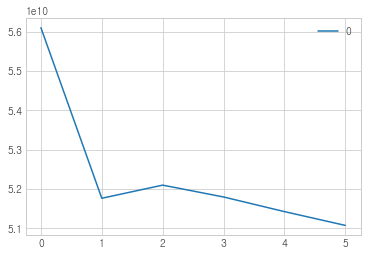

In [20]:
pd.DataFrame(scaler.inverse_transform(fit.reshape(-1,1))).plot()

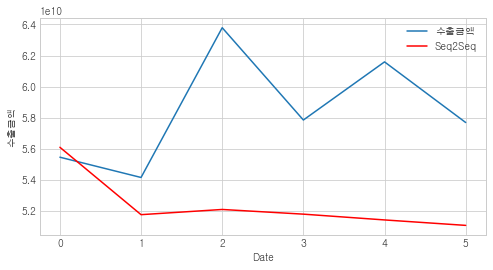

In [21]:
df2 = pd.read_csv('실제값.csv')
plt.figure(figsize=(8,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(df2, label='수출금액')
plt.plot(pd.DataFrame(scaler.inverse_transform(fit.reshape(-1,1))), label='Seq2Seq',color='red')
plt.legend()

In [22]:
pred = pd.DataFrame(scaler.inverse_transform(fit.reshape(-1,1)))

In [23]:
rmse = math.sqrt(mean_squared_error(df2['한국수출금액'], pred[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((df2['한국수출금액']- pred[0])/ df2['한국수출금액'])*100) )

RMSE: 7379971350.123766
MAPE: 10.3924422206377


In [24]:
pd.DataFrame(scaler.inverse_transform(fit.reshape(-1,1)))

,0
0,56097988608.00000
1,51761582080.00000
2,52095700992.00000
3,51794522112.00000
4,51422371840.00000
5,51071623168.00000
